# Anomaly Detection in the Service Mesh

This Jupyter Notebook contains the dataset and machine learning model used in [the accompanying blog post](https://www.fosdick.io/2018/04/17/anomaly-detection-in-the-service-mesh.html).

## Abstract

Microservice architectures enable the continuous delivery and deployment of large, complex applications.  With this architecture choice comes the challenge of connecting, managing, and securing communications between the various microservices.  Recent application level denial of service attacks which target backend services have demonstrated a rising attack vector that is capable of bringing down enterprise level systems with minimal cost and effort.  By targeting expensive services using readily available cloud computing services, a single user is capable of backing up an entire system and causing widespread outages.

This project seeks to research and better understand the feasibility of using machine learning models to analyze traffic between microservices in order to perform anomaly detection in the service mesh.  The eventual goal of this research is to utilize these models to perform real time policy enforcement decisions based on changes in requests between services.

## Explore the Data

In [1]:
# Load the data
import os
import pandas as pd

MIXER_DATA_CSV = "data-mixer.csv"

def load_mixer_data(data_path = MIXER_DATA_CSV):
    return pd.read_csv(data_path)

mixer_data = load_mixer_data()
mixer_data.head()

,destination_ip,latency,level,method,protocol,request_size,response_code,response_size,source_ip,url,severity,timestamp
0,AAAAAAAAAAAAAP//CjACBQ==,91.045ms,info,GET,http,0,200,0,CoAABQ==,/productpage,INFO,2018-03-03T04:00:28.819536Z
1,AAAAAAAAAAAAAP//CjACCQ==,68.206ms,info,GET,http,0,200,0,CjACBQ==,/productpage,INFO,2018-03-03T04:00:28.837821Z
2,AAAAAAAAAAAAAP//CjABCA==,8.22ms,info,GET,http,0,200,178,CjACCQ==,/details/0,INFO,2018-03-03T04:00:28.852134Z
3,AAAAAAAAAAAAAP//CjABCQ==,23.5ms,info,GET,http,0,200,375,CjACCQ==,/reviews/0,INFO,2018-03-03T04:00:28.868748Z
4,AAAAAAAAAAAAAP//CjACCA==,6.21ms,info,GET,http,0,200,48,CjABCQ==,/ratings/0,INFO,2018-03-03T04:00:28.882584Z


In [2]:
mixer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174103 entries, 0 to 174102
Data columns (total 12 columns):
destination_ip    174103 non-null object
latency           174103 non-null object
level             174103 non-null object
method            174103 non-null object
protocol          174103 non-null object
request_size      174103 non-null int64
response_code     174103 non-null int64
response_size     174103 non-null int64
source_ip         174039 non-null object
url               174103 non-null object
severity          174103 non-null object
timestamp         174103 non-null object
dtypes: int64(3), object(9)
memory usage: 15.9+ MB


In [3]:
mixer_data["destination_ip"].value_counts()

AAAAAAAAAAAAAP//CjABCA==    37108
AAAAAAAAAAAAAP//CjACBQ==    29980
AAAAAAAAAAAAAP//CjACCQ==    29579
AAAAAAAAAAAAAP//CjACCA==    19607
AAAAAAAAAAAAAP//CjAACA==    12485
AAAAAAAAAAAAAP//CjABCQ==    12339
AAAAAAAAAAAAAP//CjADBw==    12285
AAAAAAAAAAAAAP//CjACDw==     7816
AAAAAAAAAAAAAP//CjACDA==     7757
AAAAAAAAAAAAAP//CjACDg==     5147
Name: destination_ip, dtype: int64

In [4]:
# Since everything was logged at a level of info, we can discard this data
mixer_data["level"].value_counts()

info    174103
Name: level, dtype: int64

In [5]:
# There are some interesting request types in here that seem to be related to malicious traffic
mixer_data["method"].value_counts()

GET         174067
HEAD            24
POST             8
PROPFIND         2
OPTIONS          2
Name: method, dtype: int64

In [6]:
# Since HTTP was the only recorded protocol, we can discard this data
mixer_data["protocol"].value_counts()

http    174103
Name: protocol, dtype: int64

In [7]:
# It looks like we might have malicious data and 2 invalid response codes here
mixer_data["response_code"].value_counts()

 200           173627
 503              249
 404              150
 426               47
 400               16
 302               12
-908571056          1
 1609231952         1
Name: response_code, dtype: int64

In [8]:
mixer_data["source_ip"].value_counts()

CjACCQ==    58792
CjACBQ==    29579
CjACDA==    15425
CjAACA==    12449
CjABCQ==    12305
CoAABA==     9607
CoAABQ==     9506
CoAAAw==     9328
CjACAQ==     9291
CjACDw==     7757
Name: source_ip, dtype: int64

In [9]:
# We can see malicious traffic in which web crawlers were searching for vulnerable logins and sensitive files
mixer_data["url"].value_counts()

/productpage                                                                                74907
/reviews/0                                                                                  37109
/details/0                                                                                  37108
/ratings/0                                                                                  24754
/                                                                                             101
/scripts/setup.php                                                                              9
/phpMyAdmin/scripts/setup.php                                                                   7
/phpmyadmin/scripts/setup.php                                                                   6
/login                                                                                          6
/logout                                                                                         6
/ccvv               

In [10]:
# Since everything was logged at a severity level INFO, we can discard this data
mixer_data["severity"].value_counts()

INFO    174103
Name: severity, dtype: int64

In [11]:
mixer_data.describe()

,request_size,response_code,response_size
count,174103.000000,1.741030e+05,174103.000000
mean,0.002470,4.225098e+03,2094.296663
std,0.542487,4.428957e+06,2493.042869
min,0.000000,-9.085711e+08,0.000000
25%,0.000000,2.000000e+02,178.000000
50%,0.000000,2.000000e+02,375.000000
75%,0.000000,2.000000e+02,4415.000000
max,208.000000,1.609232e+09,5849.000000


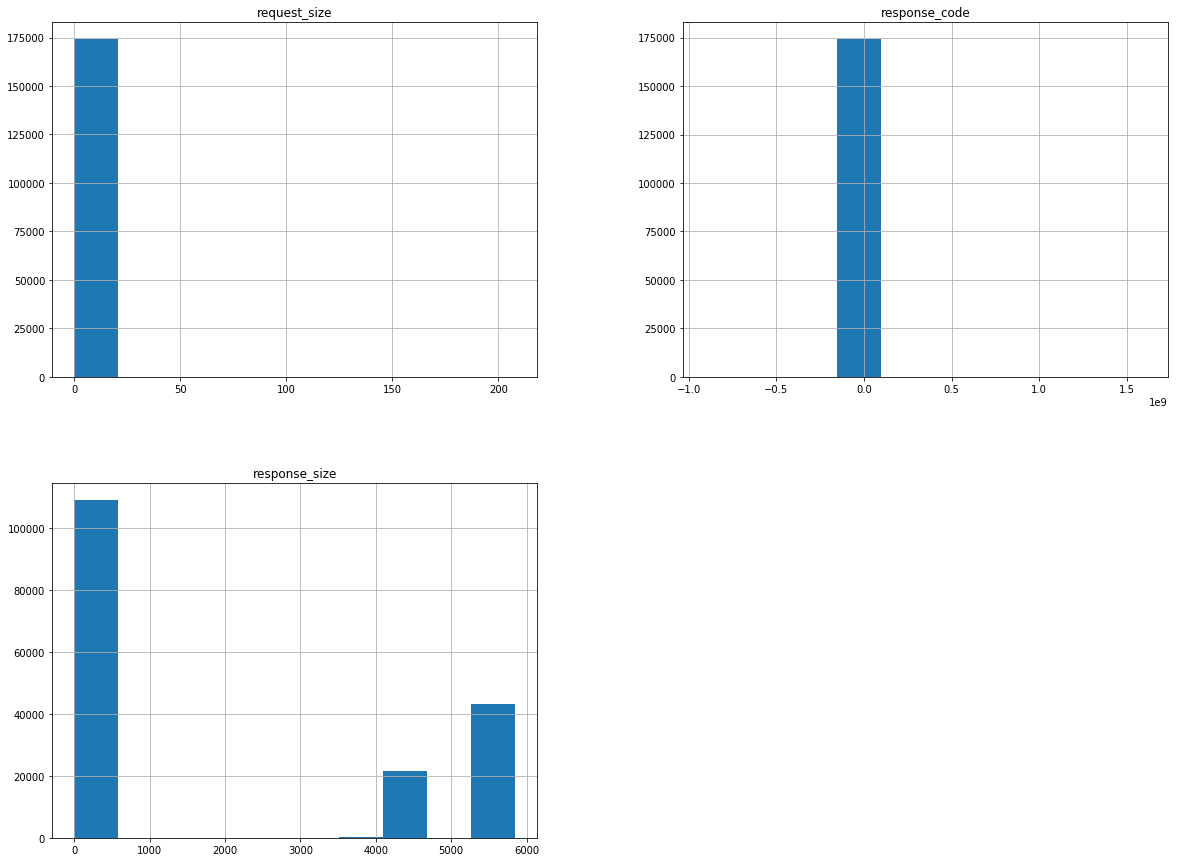

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
mixer_data.hist(figsize=(20, 15))
plt.show()

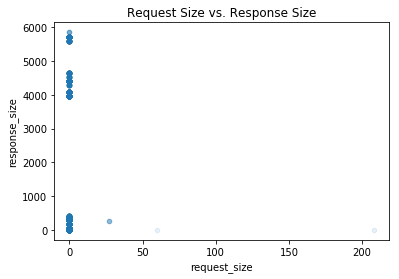

In [13]:
mixer_data.plot(kind="scatter", x="request_size", y="response_size", title="Request Size vs. Response Size", alpha=0.1)

## Prepare the Data

In [14]:
# Let's get rid of the columns that we aren't going to use
mixer_data_clean = mixer_data.drop(["latency", "level", "protocol", "response_code", "severity", "timestamp"], axis=1).dropna()
mixer_data_clean.head()

,destination_ip,method,request_size,response_size,source_ip,url
0,AAAAAAAAAAAAAP//CjACBQ==,GET,0,0,CoAABQ==,/productpage
1,AAAAAAAAAAAAAP//CjACCQ==,GET,0,0,CjACBQ==,/productpage
2,AAAAAAAAAAAAAP//CjABCA==,GET,0,178,CjACCQ==,/details/0
3,AAAAAAAAAAAAAP//CjABCQ==,GET,0,375,CjACCQ==,/reviews/0
4,AAAAAAAAAAAAAP//CjACCA==,GET,0,48,CjABCQ==,/ratings/0


In [15]:
# Converting text labels to numbers will make the data easier for ML algorithms to handle
# We can use Pandas' factorize() method to convert string categorical features to integer categorical features

url_cat = mixer_data_clean["url"]
url_cat_encoded, url_categories = url_cat.factorize()
url_cat_encoded

array([0, 0, 1, ..., 1, 2, 3])

In [16]:
method_cat = mixer_data_clean["method"]
method_cat_encoded, method_categories = method_cat.factorize()
method_cat_encoded

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
# There were some values of source IP that weren't pulled correctly
sip_cat = mixer_data_clean["source_ip"]
sip_cat_encoded, sip_categories = sip_cat.factorize()
sip_cat_encoded

array([0, 1, 2, ..., 2, 2, 3])

In [18]:
dip_cat = mixer_data_clean["destination_ip"]
dip_cat_encoded, dip_categories = dip_cat.factorize()
dip_cat_encoded

array([0, 1, 2, ..., 2, 3, 4])

In [19]:
url_categories

Index([u'/productpage', u'/details/0', u'/reviews/0', u'/ratings/0', u'/',
       u'/administrator/index.php', u'/.git/config', u'/manager/html',
       u'/ccvv', u'/myadmin/scripts/setup.php',
       u'/resources/memberCss/img/body/ocean.jpg',
       u'/index.php?page=/etc/passwd', u'/.svn/wc.db', u'/.hg/hgrc',
       u'/.ssh/id_rsa', u'/sftp_config.json', u'/.idea/WebServers.xml',
       u'/.DS_Store', u'/favicon.ico',
       u'/index.php?option=com_joomanager&controller=details&task=download&path=configuration.php',
       u'/.git/index', u'/wp-login.php', u'/wp/wp-login.php',
       u'/wordpress/wp-login.php', u'/blog/wp-login.php',
       u'/currentsetting.htm',
       u'/PluginView/zx425/FrontContent/images/logo.png', u'/cgi/common.cgi',
       u'/stssys.htm', u'/command.php',
       u'/w00tw00t.at.blackhats.romanian.anti-sec:)',
       u'/phpMyAdmin/scripts/setup.php', u'/phpmyadmin/scripts/setup.php',
       u'/pma/scripts/setup.php', u'/MyAdmin/scripts/setup.php',
       u'/ph

In [20]:
method_categories

Index([u'GET', u'HEAD', u'PROPFIND', u'POST', u'OPTIONS'], dtype='object')

In [21]:
sip_categories

Index([u'CoAABQ==', u'CjACBQ==', u'CjACCQ==', u'CjABCQ==', u'CoAAAw==',
       u'CoAABA==', u'CjAACA==', u'CjACAQ==', u'CjACDw==', u'CjACDA=='],
      dtype='object')

In [22]:
dip_categories

Index([u'AAAAAAAAAAAAAP//CjACBQ==', u'AAAAAAAAAAAAAP//CjACCQ==',
       u'AAAAAAAAAAAAAP//CjABCA==', u'AAAAAAAAAAAAAP//CjABCQ==',
       u'AAAAAAAAAAAAAP//CjACCA==', u'AAAAAAAAAAAAAP//CjADBw==',
       u'AAAAAAAAAAAAAP//CjAACA==', u'AAAAAAAAAAAAAP//CjACDw==',
       u'AAAAAAAAAAAAAP//CjACDA==', u'AAAAAAAAAAAAAP//CjACDg=='],
      dtype='object')

In [23]:
# One issue with this representation is that ML algorithms will assume that two nearby values are more similar
# Let's create one binary attribute per category (one-hot encoding)
from sklearn.preprocessing import OneHotEncoder

url_onehot_encoder = OneHotEncoder()
url_cat_1hot = url_onehot_encoder.fit_transform(url_cat_encoded.reshape(-1, 1))
url_cat_1hot

<174039x60 sparse matrix of type '<type 'numpy.float64'>'
	with 174039 stored elements in Compressed Sparse Row format>

In [24]:
method_onehot_encoder = OneHotEncoder()
method_cat_1hot = method_onehot_encoder.fit_transform(method_cat_encoded.reshape(-1, 1))
method_cat_1hot

<174039x5 sparse matrix of type '<type 'numpy.float64'>'
	with 174039 stored elements in Compressed Sparse Row format>

In [25]:
sip_onehot_encoder = OneHotEncoder()
sip_cat_1hot = sip_onehot_encoder.fit_transform(sip_cat_encoded.reshape(-1, 1))
sip_cat_1hot

<174039x10 sparse matrix of type '<type 'numpy.float64'>'
	with 174039 stored elements in Compressed Sparse Row format>

In [26]:
dip_onehot_encoder = OneHotEncoder()
dip_cat_1hot = dip_onehot_encoder.fit_transform(dip_cat_encoded.reshape(-1, 1))
dip_cat_1hot

<174039x10 sparse matrix of type '<type 'numpy.float64'>'
	with 174039 stored elements in Compressed Sparse Row format>

In [27]:
# The OneHotEncoder returns a sparse array by default, but we can convert it to a dense array if needed
url_cat_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# Definition of the CategoricalEncoder class, copied from PR #9151.

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [29]:
# The CategoricalEncoder expects a 2D array containing one or more categorical input features
# We need to reshape url_cat to a 2D array

url_cat_encoder = CategoricalEncoder()
url_cat_reshaped = url_cat.values.reshape(-1, 1)
url_cat_1hot = url_cat_encoder.fit_transform(url_cat_reshaped)
url_cat_1hot

<174039x60 sparse matrix of type '<type 'numpy.float64'>'
	with 174039 stored elements in Compressed Sparse Row format>

In [30]:
method_cat_encoder = CategoricalEncoder()
method_cat_reshaped = method_cat.values.reshape(-1, 1)
method_cat_1hot = method_cat_encoder.fit_transform(method_cat_reshaped)
method_cat_1hot

<174039x5 sparse matrix of type '<type 'numpy.float64'>'
	with 174039 stored elements in Compressed Sparse Row format>

In [31]:
sip_cat_encoder = CategoricalEncoder()
sip_cat_reshaped = sip_cat.values.reshape(-1, 1)
sip_cat_1hot = sip_cat_encoder.fit_transform(sip_cat_reshaped)
sip_cat_1hot

<174039x10 sparse matrix of type '<type 'numpy.float64'>'
	with 174039 stored elements in Compressed Sparse Row format>

In [32]:
dip_cat_encoder = CategoricalEncoder()
dip_cat_reshaped = dip_cat.values.reshape(-1, 1)
dip_cat_1hot = dip_cat_encoder.fit_transform(dip_cat_reshaped)
dip_cat_1hot

<174039x10 sparse matrix of type '<type 'numpy.float64'>'
	with 174039 stored elements in Compressed Sparse Row format>

In [33]:
url_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
url_cat_encoder.categories_

[array(['/', '/.DS_Store', '/.git/config', '/.git/index', '/.hg/hgrc',
        '/.idea/WebServers.xml', '/.ssh/id_rsa', '/.svn/wc.db',
        '/.well-known/security.txt', '/CFIDE/administrator/',
        '/MyAdmin/scripts/setup.php', '/PMA2012/',
        '/PluginView/zx425/FrontContent/images/logo.png', '/admin',
        '/administrator/index.php', '/blog/wp-login.php', '/ccvv',
        '/cgi/common.cgi', '/command.php', '/currentsetting.htm',
        '/details/0', '/favicon.ico', '/getcfg.php', '/hndUnblock.cgi',
        '/index.action', '/index.htm', '/index.html', '/index.jsp',
        '/index.php?option=com_joomanager&controller=details&task=download&path=configuration.php',
        '/index.php?page=/etc/passwd', '/login', '/login.action',
        '/logout', '/manager/html', '/moo', '/myadmin/scripts/setup.php',
        '/phpMyAdmin-2.10.0.0/scripts/setup.php', '/phpMyAdmin/',
        '/phpMyAdmin/scripts/db_setup.init.php',
        '/phpMyAdmin/scripts/setup.php', '/phpmyadmin/',

In [35]:
method_cat_encoder.categories_

[array(['GET', 'HEAD', 'OPTIONS', 'POST', 'PROPFIND'], dtype=object)]

In [36]:
sip_cat_encoder.categories_

[array(['CjAACA==', 'CjABCQ==', 'CjACAQ==', 'CjACBQ==', 'CjACCQ==',
        'CjACDA==', 'CjACDw==', 'CoAAAw==', 'CoAABA==', 'CoAABQ=='],
       dtype=object)]

In [37]:
dip_cat_encoder.categories_

[array(['AAAAAAAAAAAAAP//CjAACA==', 'AAAAAAAAAAAAAP//CjABCA==',
        'AAAAAAAAAAAAAP//CjABCQ==', 'AAAAAAAAAAAAAP//CjACBQ==',
        'AAAAAAAAAAAAAP//CjACCA==', 'AAAAAAAAAAAAAP//CjACCQ==',
        'AAAAAAAAAAAAAP//CjACDA==', 'AAAAAAAAAAAAAP//CjACDg==',
        'AAAAAAAAAAAAAP//CjACDw==', 'AAAAAAAAAAAAAP//CjADBw=='],
       dtype=object)]

In [38]:
mixer_data_num = mixer_data_clean.drop(["destination_ip", "method", "source_ip", "url"], axis=1)
mixer_data_num.head()

,request_size,response_size
0,0,0
1,0,0
2,0,178
3,0,375
4,0,48


In [39]:
# Build a pipeline for preprocessing the numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

mixer_data_tr = num_pipeline.fit_transform(mixer_data_num)
mixer_data_tr

array([[-0.00455359, -0.84032232],
       [-0.00455359, -0.84032232],
       [-0.00455359, -0.76892728],
       ...,
       [-0.00455359, -0.76892728],
       [-0.00455359, -0.68991143],
       [-0.00455359, -0.82106972]])

In [40]:
# Create a class to select numerical or categorical columns since Scikit-Learn doesn't handle DataFrames yet
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [41]:
num_attribs = list(mixer_data_num)
cat_attribs = ["destination_ip", "method", "source_ip", "url"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [42]:
mixer_data_clean.head()

,destination_ip,method,request_size,response_size,source_ip,url
0,AAAAAAAAAAAAAP//CjACBQ==,GET,0,0,CoAABQ==,/productpage
1,AAAAAAAAAAAAAP//CjACCQ==,GET,0,0,CjACBQ==,/productpage
2,AAAAAAAAAAAAAP//CjABCA==,GET,0,178,CjACCQ==,/details/0
3,AAAAAAAAAAAAAP//CjABCQ==,GET,0,375,CjACCQ==,/reviews/0
4,AAAAAAAAAAAAAP//CjACCA==,GET,0,48,CjABCQ==,/ratings/0


In [43]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

mixer_prepared = full_pipeline.fit_transform(mixer_data_clean)
mixer_prepared

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.00455359, -0.84032232,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00455359, -0.84032232,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00455359, -0.76892728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00455359, -0.76892728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00455359, -0.68991143,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00455359, -0.82106972,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [44]:
mixer_prepared.shape

(174039, 87)

## Train the Machine Learning Model

In [45]:
# Split the data into a training set and a testing set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(mixer_prepared, test_size=0.2, random_state=42)
print "{} train + {} test".format(len(train_set), len(test_set))

139231 train + 34808 test


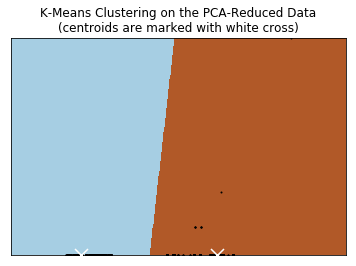

In [57]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(mixer_prepared)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-Means Clustering on the PCA-Reduced Data\n'
          '(centroids are marked with white cross)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [59]:
reduced_data.view()

array([[ 1.30778295e-01, -8.12963363e-04],
       [ 8.36563972e-03, -8.63242319e-04],
       [ 1.21318289e+00, -1.23077196e-02],
       ...,
       [ 1.21318289e+00, -1.23077196e-02],
       [ 1.00405672e+00, -9.85767102e-03],
       [ 8.63783936e-01, -5.37444098e-03]])

In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(train_set)
y_kmeans = kmeans.predict(test_set)
kmeans.cluster_centers_.shape

(2, 87)

In [49]:
kmeans.labels_

array([1, 0, 1, ..., 0, 1, 0], dtype=int32)

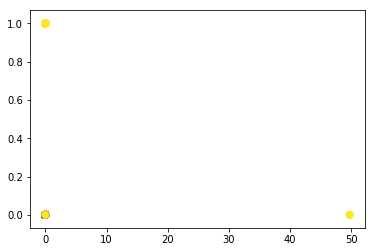

In [50]:
plt.scatter(test_set[:, 0], test_set[:, 2], c=y_kmeans, s=50, cmap='viridis')
plt.show()

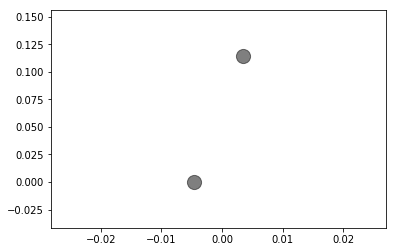

In [51]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5)
plt.show()

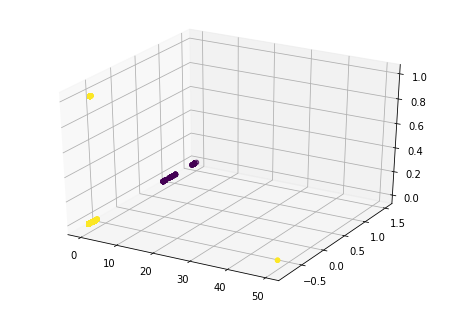

In [52]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=y_kmeans)

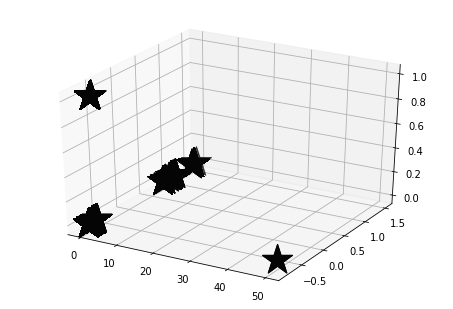

In [53]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], marker='*', c='#050505', s=1000)